# **chromaVive**

**NOTE:** 
As individuals with limited GPU power and computational resources, it is not feasible for us to replicate the extensive work done by Richard Zhang et al. in their seminal paper *"Colorful Image Colorization"* (ECCV 2016). However, we provide a **proof of concept** to demonstrate the fundamental approach to tackling the image colorization problem.

## **Color Space Conversion:** RGB & LAB

#### System Variables

In [1]:
IMG_PATH = 'image.jpeg'

#### Libraries Import

In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

#### *Original Image:* BGR to RGB

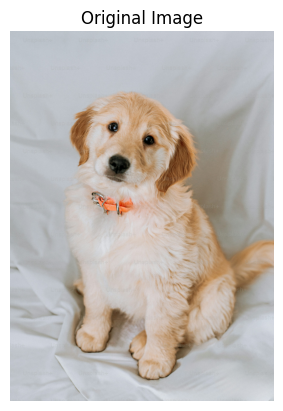

In [3]:
img = cv.imread(IMG_PATH)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')
plt.show();

#### *Original Image:* BGR to LAB

In [4]:
img = cv.imread(IMG_PATH)
img = cv.cvtColor(img, cv.COLOR_BGR2LAB)
L, a, b = cv.split(img)

#### *LAB Color Space:* Lightness (L), Green-Red (a), Blue-Yellow (b)

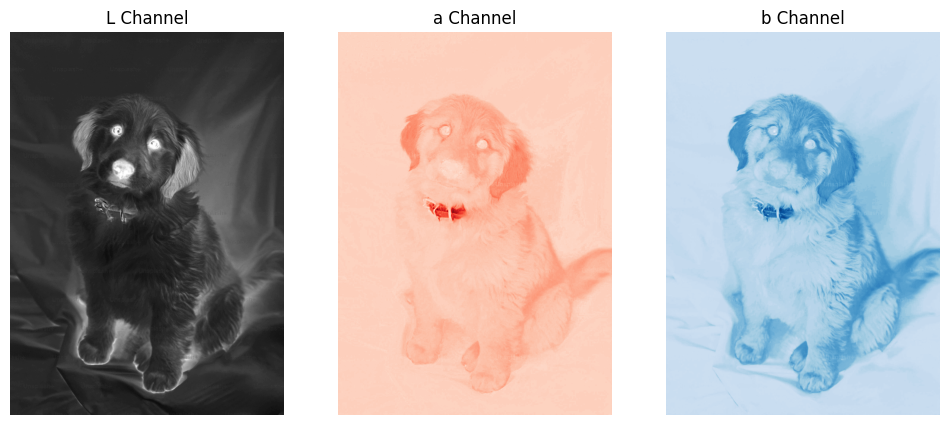

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(12, 6))

ax[0].imshow(L, cmap='binary')
ax[0].set_title('L Channel')
ax[0].axis('off')

ax[1].imshow(a, cmap='Reds')
ax[1].set_title('a Channel')
ax[1].axis('off')

ax[2].imshow(b, cmap='Blues')
ax[2].set_title('b Channel')
ax[2].axis('off')

plt.show();

#### *LAB Color Space:* Lightness (L), Green-Red-Blue-Yellow (ab)

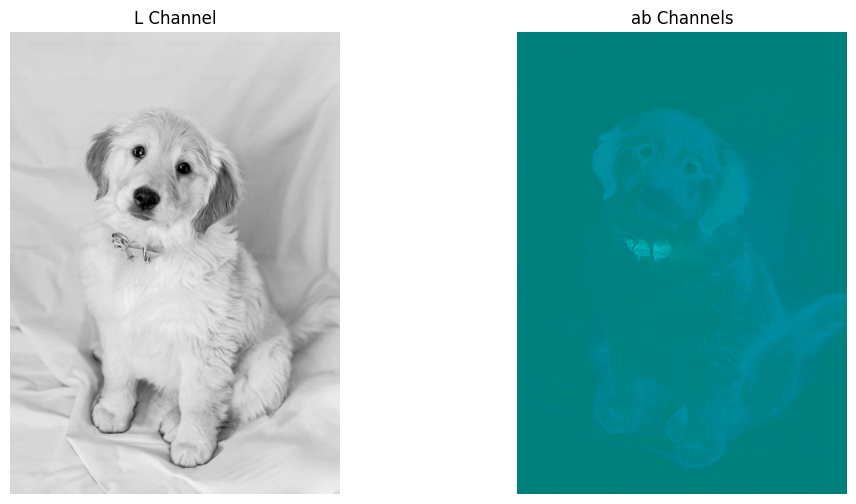

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(L, cmap='gray')
ax[0].set_title('L Channel')
ax[0].axis('off')

ax[1].imshow(cv.merge([np.zeros_like(L), a, b]), cmap='viridis')
ax[1].set_title('ab Channels')
ax[1].axis('off')

plt.show();

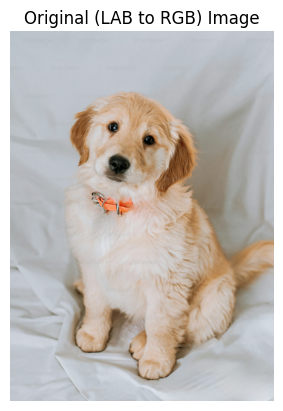

In [7]:
merged_img = cv.cvtColor(cv.merge([L, a, b]), cv.COLOR_LAB2RGB)
plt.imshow(merged_img)
plt.title('Original (LAB to RGB) Image')
plt.axis('off')
plt.show();

In [8]:
L, a, b

(array([[178, 184, 190, ..., 204, 201, 198],
        [181, 186, 193, ..., 206, 203, 200],
        [186, 191, 196, ..., 207, 204, 202],
        ...,
        [191, 191, 194, ..., 201, 197, 197],
        [181, 184, 189, ..., 196, 192, 189],
        [178, 182, 188, ..., 195, 189, 183]], dtype=uint8),
 array([[123, 123, 124, ..., 128, 128, 128],
        [123, 123, 124, ..., 128, 128, 128],
        [125, 125, 125, ..., 128, 128, 128],
        ...,
        [125, 125, 126, ..., 127, 128, 128],
        [125, 125, 125, ..., 128, 128, 128],
        [125, 125, 125, ..., 128, 129, 129]], dtype=uint8),
 array([[126, 126, 125, ..., 123, 123, 123],
        [126, 126, 125, ..., 123, 123, 123],
        [125, 125, 125, ..., 123, 123, 123],
        ...,
        [129, 129, 129, ..., 128, 128, 129],
        [131, 130, 130, ..., 129, 129, 130],
        [131, 131, 130, ..., 129, 130, 130]], dtype=uint8))

## **Bin Classification:** AB Color Space 

#### System Variables

In [9]:
k = 5

#### Libraries Import

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt

#### Bin Classification: a and b channels

In [11]:
def create_ab_bins(grid_size=16):
    a_range = torch.arange(-128, 128, grid_size)
    b_range = torch.arange(-128, 128, grid_size)
    ab_bins = torch.tensor([[a, b] for a in a_range for b in b_range])

    return ab_bins

In [12]:
ab_bins = create_ab_bins(16)
print(f'No. of bins: {ab_bins.shape[0]}')
print(f'ab_bins shape: {ab_bins.shape}')

No. of bins: 256
ab_bins shape: torch.Size([256, 2])


In [13]:
ab_bins

tensor([[-128, -128],
        [-128, -112],
        [-128,  -96],
        [-128,  -80],
        [-128,  -64],
        [-128,  -48],
        [-128,  -32],
        [-128,  -16],
        [-128,    0],
        [-128,   16],
        [-128,   32],
        [-128,   48],
        [-128,   64],
        [-128,   80],
        [-128,   96],
        [-128,  112],
        [-112, -128],
        [-112, -112],
        [-112,  -96],
        [-112,  -80],
        [-112,  -64],
        [-112,  -48],
        [-112,  -32],
        [-112,  -16],
        [-112,    0],
        [-112,   16],
        [-112,   32],
        [-112,   48],
        [-112,   64],
        [-112,   80],
        [-112,   96],
        [-112,  112],
        [ -96, -128],
        [ -96, -112],
        [ -96,  -96],
        [ -96,  -80],
        [ -96,  -64],
        [ -96,  -48],
        [ -96,  -32],
        [ -96,  -16],
        [ -96,    0],
        [ -96,   16],
        [ -96,   32],
        [ -96,   48],
        [ -96,   64],
        [ 

#### *AB Bin Classification:* Visualization

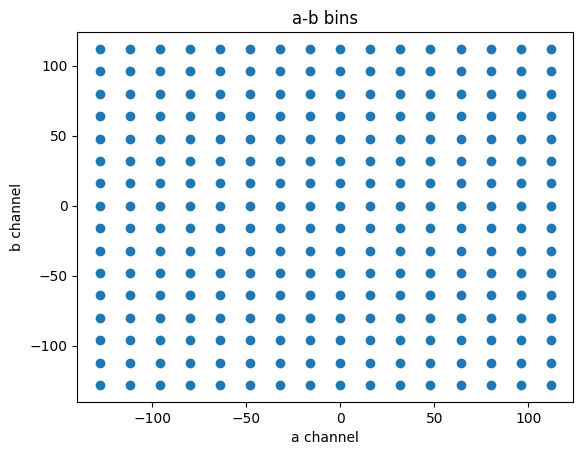

In [14]:
plt.plot(ab_bins[:, 0], ab_bins[:, 1], 'o')
plt.xlabel('a channel')
plt.ylabel('b channel')
plt.title('a-b bins')
plt.show();

#### *K-nearest bins*: Implementation

In [15]:
def k_nearest_neighbours(ab_target, ab_reference, k=5):
    """
    Find the k nearest neighbors in the ab color space to a target point.

    Parameters:
    ----------
    ab_target : torch.Tensor
        Target point in the form of (a, b).

    ab_reference : torch.Tensor
        Reference points, shape (n, 2).

    k : int, optional
        Number of nearest neighbors to find (default is 5).

    Returns:
    -------
    torch.Tensor
        k nearest points in the ab color space.

    torch.Tensor
        Distances of the k nearest points from the target.
    """
     
    ab_target = ab_target.unsqueeze(0)                              # (1, 2)
    distances = torch.linalg.norm(ab_reference - ab_target, dim=1)  # (n, ) L2 distances
    k_distances = torch.argsort(distances)[:k]
    return k_distances, distances[k_distances]

def gaussian_encoding(ab_target, ab_reference, k=5, std_dev=5.0):
    """
    Calculate Gaussian weights for ab_reference based on distance to ab_target.

    Parameters:
    ----------
    ab_target : torch.Tensor
        Target point in the form of (a, b).

    ab_reference : torch.Tensor
        Reference points, shape (n, 2).

    std_dev : float, optional
        Standard deviation for the Gaussian distribution (default is 5.0).

    Returns:
    -------
    torch.Tensor
        Normalized Gaussian weights for each reference point.
    """
    
    k_distances_indices, k_distance_values = k_nearest_neighbours(ab_target, ab_reference, k)
    weights = torch.exp(-0.5 * (k_distance_values / std_dev) ** 2)  # (k, ) gaussian encoding                  
    soft_weights = weights / torch.sum(weights)                     # (k, ) normalized weights

    n = ab_reference.shape[0]
    soft_weights_encoded = torch.zeros(n)                           # (n, ) encoded weights
    soft_weights_encoded[k_distances_indices] = soft_weights
    return soft_weights_encoded

In [16]:
ab_target = torch.randint(-128, 128, (2,), dtype=torch.float32)
soft_encoded_weights = gaussian_encoding(ab_target, ab_bins, k)
soft_encoded_weights

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+

In [17]:
print(f'Sum of weights: {soft_encoded_weights.sum():.4f}')
print(f'Max weight: {soft_encoded_weights.max():.4f}')
print(f'Min weight: {soft_encoded_weights.min():.4f}')
print(f'Soft Encoded Weights\' shape: {soft_encoded_weights.shape}')

Sum of weights: 1.0000
Max weight: 0.9857
Min weight: 0.0000
Soft Encoded Weights' shape: torch.Size([256])


#### *K-nearest bins*: Visualization

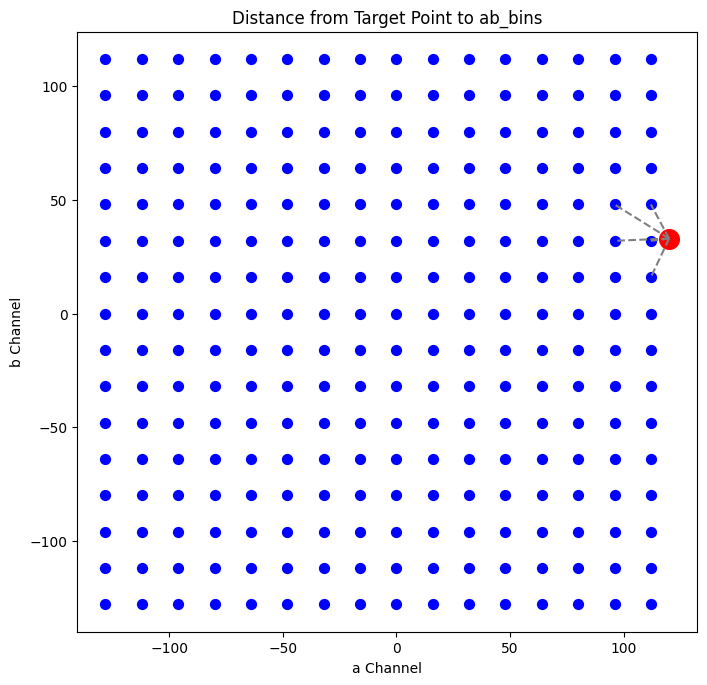

In [18]:
plt.figure(figsize=(8, 16))
plt.scatter(ab_bins[:, 0], ab_bins[:, 1], color='blue', s=50)
plt.scatter(ab_target[0], ab_target[1], color='red', s=200)
for i in range(len(ab_bins)):
    plt.plot([ab_target[0], ab_bins[i, 0]], [ab_target[1], ab_bins[i, 1]], color='gray', linestyle='--') if soft_encoded_weights[i] > 0 else None
plt.title('Distance from Target Point to ab_bins')
plt.xlabel('a Channel')
plt.ylabel('b Channel')
plt.gca().set_aspect('equal', adjustable='box')
plt.show();

## **ImageNet**: Downscaled Versions

#### System Variables

In [19]:
img_size = 32
path = f'./datasets/ImageNet {img_size}X{img_size}/Imagenet#_train'
extraction_path = f'datasets/extracted/LABEL/imagenet#_data_batch_'

#### Libraries Import

In [20]:
import os
import random
import pickle
import numpy as np
import matplotlib.pyplot as plt

#### ImageNet Extraction

In [21]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo)
    return dict

In [22]:
def load_databatch(data_folder, idx, img_size=32):
    data_file = os.path.join(data_folder, 'train_data_batch_')

    d = unpickle(data_file + str(idx))
    x = d['data']
    y = d['labels']
    mean_image = d['mean']

    x = x/np.float32(255)
    mean_image = mean_image/np.float32(255)

    # Labels are indexed from 1, shift it so that indexes start at 0
    y = [i-1 for i in y]
    data_size = x.shape[0]

    x -= mean_image

    img_size2 = img_size * img_size

    x = np.dstack((x[:, :img_size2], x[:, img_size2:2*img_size2], x[:, 2*img_size2:]))
    x = x.reshape((x.shape[0], img_size, img_size, 3)).transpose(0, 3, 1, 2)

    # create mirrored images
    X_train = x[0:data_size, :, :, :]
    Y_train = y[0:data_size]
    X_train_flip = X_train[:, :, :, ::-1]
    Y_train_flip = Y_train
    X_train = np.concatenate((X_train, X_train_flip), axis=0)
    Y_train = np.concatenate((Y_train, Y_train_flip), axis=0)

    return dict(
        X_train=X_train.astype('float32'),
        Y_train=Y_train.astype('int32'),
        mean=mean_image)

#### *ImageNet Local*: Inception & Extraction

In [23]:
count = 0
for i in range(10):
    print(f'Loading batch {i+1}...')
    data = load_databatch(path.replace('#', str(img_size)), i+1, img_size)

    image_count = data['X_train'].shape[0]
    print(f'Loaded batch: {i+1} with {image_count} images')

    print('Saving data...')
    np.save(f'{extraction_path.replace('#', str(img_size)).replace('LABEL', 'X_train')}{i+1}.npy', data['X_train'])     # X_train: (N, C, H, W)
    np.save(f'{extraction_path.replace('#', str(img_size)).replace('LABEL', 'Y_train')}{i+1}.npy', data['Y_train'])     # Y_train: (N, )
    np.save(f'{extraction_path.replace('#', str(img_size)).replace('LABEL', 'mean')}{i+1}.npy', data['mean'])           # mean: (C * H * W, )

    count += image_count

print(f'Total images: {count}')

Loading batch 1...
Loaded batch: 1 with 256232 images
Saving data...
Loading batch 2...
Loaded batch: 2 with 256232 images
Saving data...
Loading batch 3...
Loaded batch: 3 with 256232 images
Saving data...
Loading batch 4...
Loaded batch: 4 with 256232 images
Saving data...
Loading batch 5...
Loaded batch: 5 with 256232 images
Saving data...
Loading batch 6...
Loaded batch: 6 with 256232 images
Saving data...
Loading batch 7...
Loaded batch: 7 with 256232 images
Saving data...
Loading batch 8...
Loaded batch: 8 with 256232 images
Saving data...
Loading batch 9...
Loaded batch: 9 with 256232 images
Saving data...
Loading batch 10...
Loaded batch: 10 with 256246 images
Saving data...
Total images: 2562334


In [24]:
def extract_arrays(idx, img_size=img_size):
    data = {}
    data['X_train'] = np.load(f'{extraction_path.replace('#', str(img_size)).replace('LABEL', 'X_train')}{i+1}.npy')
    data['Y_train'] = np.load(f'{extraction_path.replace('#', str(img_size)).replace('LABEL', 'Y_train')}{i+1}.npy')
    data['mean'] = np.load(f'{extraction_path.replace('#', str(img_size)).replace('LABEL', 'mean')}{i+1}.npy')

    return data

#### ImageNet Testing

In [25]:
idx = random.randint(1, 10)
data = extract_arrays(idx, img_size)
print('Data extracted from batch:', idx)
data['X_train'].shape, data['Y_train'].shape, data['mean'].shape

Data extracted from batch: 3


((256246, 3, 32, 32), (256246,), (3072,))

In [26]:
num_images = data['X_train'].shape[0]
index = random.randint(0, num_images-1)
data['X_train'][index].shape

(3, 32, 32)

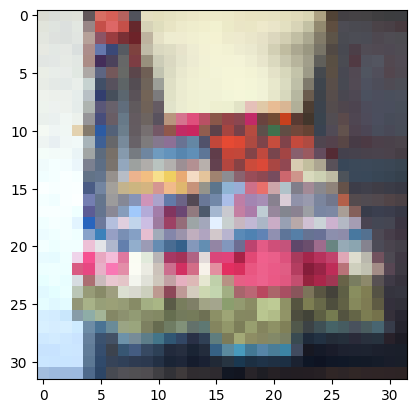

In [27]:
img = data['X_train'][random.randint(0, num_images-1)].transpose(1, 2, 0)
img = np.clip(img * 255 + 128, 0, 255).astype(np.uint8)
plt.imshow(img);